In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import itertools
import random
from random import shuffle 

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from subprocess import check_output
import cv2
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

C:\Users\done-\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

In [3]:
train_dir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/')
test_dir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/validation/')

info sul dataset e i label

In [4]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("D:/uni/KAGGLE COMPETITIONS/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [5]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [6]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('D:/uni/KAGGLE COMPETITIONS/10-monkey-species/training/'+ label +'/'+ imgfile)
        print(img.shape)
        print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                
(678, 800, 3)
n4
(811, 1024, 3)
n4
(866, 1300, 3)
n4


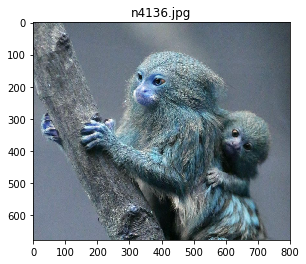

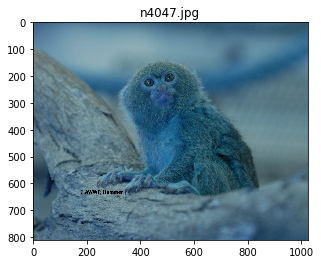

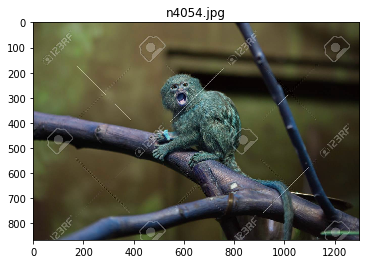

In [7]:
print(labels[4])
image_show(3,'n4')

 black_headed_night_monkey     
(2304, 3456, 3)
n8
(848, 1200, 3)
n8
(700, 601, 3)
n8


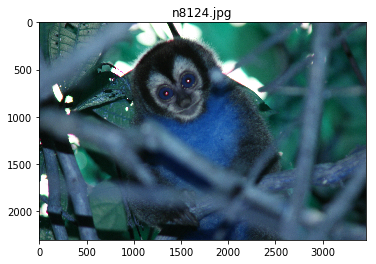

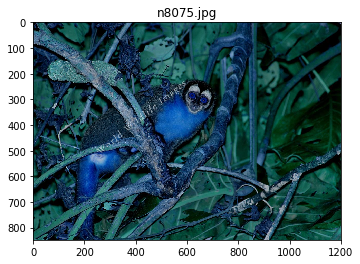

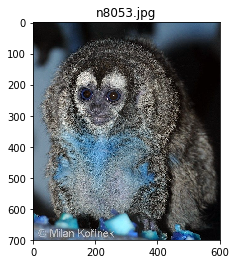

In [8]:
print(labels[8])
image_show(3,'n8')

In [7]:
height=224
width=224
channels=3
batch_size = 64
num_classes = 10
data_augmentation = True

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split= 0.2,
        fill_mode='nearest')

#### Train

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=1234,
                                                    shuffle=True,
                                                    subset= 'training',
                                                    class_mode='categorical')

Found 880 images belonging to 10 classes.


#### Validation

In [10]:
validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=1234,
                                                    shuffle=True,
                                                    subset= 'validation',
                                                    class_mode='categorical')

Found 217 images belonging to 10 classes.


#### Test

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=1234,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 272 images belonging to 10 classes.


In [12]:
train_num = train_generator.samples
validation_num = validation_generator.samples
test_num = test_generator.samples

## Modello

### Con include_top = False si escludono i 3 layer fully connected 

In [13]:
pretrain_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [14]:
pretrain_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
model = Sequential()

model.add(pretrain_model)    #Aggiungo a model il VGG16
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax'))

In [16]:
model.layers[0].trainable = False 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 27,565,386
Trainable params: 12,850,698
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
fBestModel = 'best_model.h5'
best_model = ModelCheckpoint(fBestModel, 
                             monitor = 'val_acc', verbose=1, 
                             save_best_only=True) #Imposto questa callback, in modo che il modello salvi i parametri migliori

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [21]:
history = model.fit_generator(train_generator,
                              epochs=50, verbose = 1, validation_data = validation_generator, callbacks=[best_model])

Epoch 1/50
14/14 [==============================] - ETA: 4:35 - loss: 2.7002 - acc: 0.062 - ETA: 2:28 - loss: 2.6311 - acc: 0.078 - ETA: 1:44 - loss: 2.5841 - acc: 0.072 - ETA: 1:20 - loss: 2.5145 - acc: 0.097 - ETA: 1:04 - loss: 2.4748 - acc: 0.112 - ETA: 52s - loss: 2.4485 - acc: 0.117 - ETA: 42s - loss: 2.4225 - acc: 0.12 - ETA: 34s - loss: 2.3941 - acc: 0.13 - ETA: 33s - loss: 2.3783 - acc: 0.14 - ETA: 25s - loss: 2.3572 - acc: 0.15 - ETA: 18s - loss: 2.3367 - acc: 0.15 - ETA: 11s - loss: 2.3251 - acc: 0.16 - ETA: 5s - loss: 2.3075 - acc: 0.1707 - 104s 7s/step - loss: 2.2901 - acc: 0.1786 - val_loss: 1.8990 - val_acc: 0.3041

Epoch 00001: val_acc improved from -inf to 0.30415, saving model to best_model.h5
Epoch 2/50
14/14 [==============================] - ETA: 47s - loss: 1.8534 - acc: 0.31 - ETA: 43s - loss: 1.8675 - acc: 0.29 - ETA: 39s - loss: 1.8668 - acc: 0.32 - ETA: 36s - loss: 1.8353 - acc: 0.34 - ETA: 32s - loss: 1.8456 - acc: 0.34 - ETA: 29s - loss: 1.8477 - acc: 0.34 - 


Epoch 00023: val_acc did not improve from 0.74654
Epoch 24/50
14/14 [==============================] - ETA: 47s - loss: 0.6545 - acc: 0.81 - ETA: 43s - loss: 0.5965 - acc: 0.80 - ETA: 39s - loss: 0.5614 - acc: 0.82 - ETA: 36s - loss: 0.5643 - acc: 0.82 - ETA: 32s - loss: 0.5569 - acc: 0.82 - ETA: 29s - loss: 0.5286 - acc: 0.84 - ETA: 25s - loss: 0.5530 - acc: 0.83 - ETA: 21s - loss: 0.5858 - acc: 0.81 - ETA: 18s - loss: 0.5887 - acc: 0.80 - ETA: 14s - loss: 0.5825 - acc: 0.81 - ETA: 10s - loss: 0.5805 - acc: 0.80 - ETA: 7s - loss: 0.5913 - acc: 0.7986 - ETA: 3s - loss: 0.6024 - acc: 0.798 - 67s 5s/step - loss: 0.6091 - acc: 0.7951 - val_loss: 0.9873 - val_acc: 0.6498

Epoch 00024: val_acc did not improve from 0.74654
Epoch 25/50
14/14 [==============================] - ETA: 47s - loss: 0.6014 - acc: 0.81 - ETA: 43s - loss: 0.5361 - acc: 0.85 - ETA: 39s - loss: 0.5143 - acc: 0.84 - ETA: 36s - loss: 0.5149 - acc: 0.83 - ETA: 32s - loss: 0.5371 - acc: 0.81 - ETA: 29s - loss: 0.5376 - acc


Epoch 00035: val_acc did not improve from 0.76959
Epoch 36/50
14/14 [==============================] - ETA: 46s - loss: 0.4688 - acc: 0.82 - ETA: 43s - loss: 0.4442 - acc: 0.85 - ETA: 39s - loss: 0.4177 - acc: 0.86 - ETA: 36s - loss: 0.4122 - acc: 0.85 - ETA: 32s - loss: 0.3990 - acc: 0.86 - ETA: 29s - loss: 0.3906 - acc: 0.86 - ETA: 25s - loss: 0.3870 - acc: 0.87 - ETA: 21s - loss: 0.3990 - acc: 0.86 - ETA: 18s - loss: 0.3955 - acc: 0.87 - ETA: 14s - loss: 0.4080 - acc: 0.86 - ETA: 10s - loss: 0.4054 - acc: 0.87 - ETA: 7s - loss: 0.3982 - acc: 0.8737 - ETA: 3s - loss: 0.3936 - acc: 0.877 - 66s 5s/step - loss: 0.3869 - acc: 0.8831 - val_loss: 0.7129 - val_acc: 0.7788

Epoch 00036: val_acc improved from 0.76959 to 0.77880, saving model to best_model.h5
Epoch 37/50
14/14 [==============================] - ETA: 46s - loss: 0.5075 - acc: 0.85 - ETA: 43s - loss: 0.4836 - acc: 0.83 - ETA: 39s - loss: 0.4467 - acc: 0.84 - ETA: 36s - loss: 0.4139 - acc: 0.87 - ETA: 32s - loss: 0.4203 - acc: 0


Epoch 00047: val_acc did not improve from 0.78341
Epoch 48/50
14/14 [==============================] - ETA: 46s - loss: 0.2863 - acc: 0.87 - ETA: 43s - loss: 0.2865 - acc: 0.90 - ETA: 39s - loss: 0.2918 - acc: 0.90 - ETA: 36s - loss: 0.2848 - acc: 0.91 - ETA: 32s - loss: 0.2807 - acc: 0.91 - ETA: 28s - loss: 0.2817 - acc: 0.91 - ETA: 25s - loss: 0.3017 - acc: 0.90 - ETA: 21s - loss: 0.3063 - acc: 0.91 - ETA: 18s - loss: 0.3069 - acc: 0.90 - ETA: 14s - loss: 0.3016 - acc: 0.91 - ETA: 10s - loss: 0.3061 - acc: 0.90 - ETA: 7s - loss: 0.2980 - acc: 0.9115 - ETA: 3s - loss: 0.3062 - acc: 0.908 - 66s 5s/step - loss: 0.3036 - acc: 0.9119 - val_loss: 0.8383 - val_acc: 0.7143

Epoch 00048: val_acc did not improve from 0.78341
Epoch 49/50
14/14 [==============================] - ETA: 35s - loss: 0.4694 - acc: 0.85 - ETA: 38s - loss: 0.3770 - acc: 0.88 - ETA: 36s - loss: 0.3819 - acc: 0.87 - ETA: 34s - loss: 0.3640 - acc: 0.89 - ETA: 31s - loss: 0.3840 - acc: 0.88 - ETA: 27s - loss: 0.3728 - acc

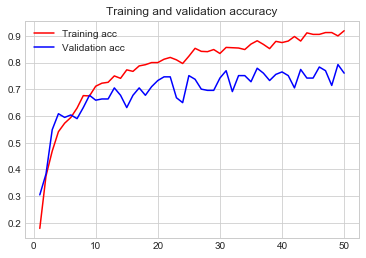

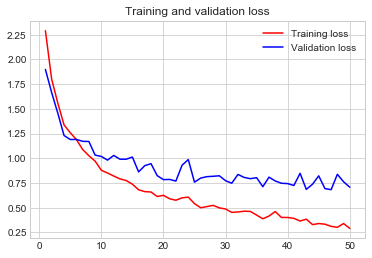

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Carico i pesi del modello che ha raggiunto la maggiore accuracy sul validation

In [19]:
model.load_weights("best_model.h5")

In [34]:
predi = model.predict_generator(test_generator, test_num // batch_size+1)

In [35]:
predict = np.argmax(predi, axis = 1)

In [36]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

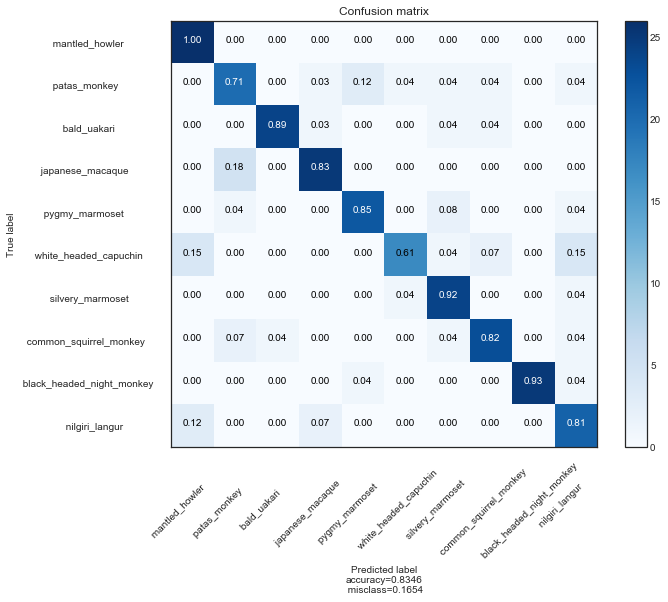

In [37]:
confusion_mtx = confusion_matrix(y_true = test_generator.classes,y_pred = predict)
# plot the confusion matrix
sns.set_style("white")
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [39]:
print(metrics.classification_report(test_generator.classes, predict,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.79      1.00      0.88        26
 patas_monkey                         0.71      0.71      0.71        28
 bald_uakari                          0.96      0.89      0.92        27
 japanese_macaque                     0.86      0.83      0.85        30
 pygmy_marmoset                       0.85      0.85      0.85        26
 white_headed_capuchin                0.89      0.61      0.72        28
 silvery_marmoset                     0.80      0.92      0.86        26
 common_squirrel_monkey               0.85      0.82      0.84        28
 black_headed_night_monkey            1.00      0.93      0.96        27
 nilgiri_langur                       0.70      0.81      0.75        26

                    avg / total       0.84      0.83      0.83       272



In [20]:
model.evaluate_generator(test_generator)

[0.5279149448170382, 0.8345588235294118]

### Il classificatore generalizza bene sul test, raggiungendo un'accuracy pari a 0.8346. La classe su cui ha performance più basse (0.61 acc) risulta essere quella del "White Headed Capuchin". Questa classe ha recall bassa: il classificatore tende a sbagliare sui False Negative, ciò significa che tende a confondere questa classe con altre. In particolar modo confonde il white headed capuchin con il mantled howler e con il nilgiri langun. Osserviamo qui sotto un confronto tra le 3 specie

white_headed_capuchin
(427, 640, 3)
n5


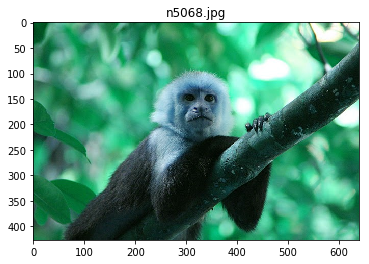

mantled_howler
(679, 1024, 3)
n0


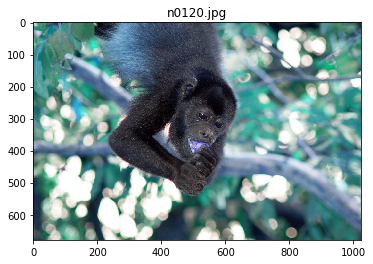

nilgiri_langur
(800, 542, 3)
n9


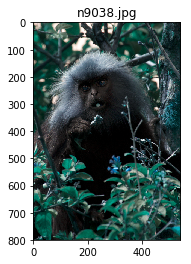

In [27]:
classi = ['n5', 'n0', 'n9']
diz = {'n5': 'white_headed_capuchin', 'n0': 'mantled_howler', 'n9': 'nilgiri_langur'}
for cl in classi:
    print(diz[cl])
    image_show(1,cl)

### Possiamo osservare che il white head capuchin assomiglia molto al mantled howler.
### Mentre rispetto al nilgiri langun possiamo notare che entrambe le razze hanno una chioma bianca in testa, motivo per il quale il classificatore tende a confondere il white head capuchin con questa classe.